<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/9.27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Value-Function Approximation


## Exercise 1 SGD
Many real-world processes can be modeled as nonlinear relationships, and SGD is a standard tool to fit those models from data.  

**Example: Predicting energy consumption in a building**  
- Energy usage depends on **temperature**, **time of day**, and **occupancy**.  
- If you plot the data, the relationship might not be linear — it curves.  
- A simple way to approximate this nonlinear relation is to fit a **polynomial function** of temperature (or time).  

Now, imagine you’re collecting data continuously:  
- You get one data point (temperature, usage) at a time.  
- Instead of waiting to collect all data and computing a full batch update, you update your model incrementally with **SGD**.  
- This makes your learning **online, adaptive, and scalable** — just like in reinforcement learning.  

---

In this exercise, approximating a cubic polynomial is a simplified version of **predicting a nonlinear real-world phenomenon**.


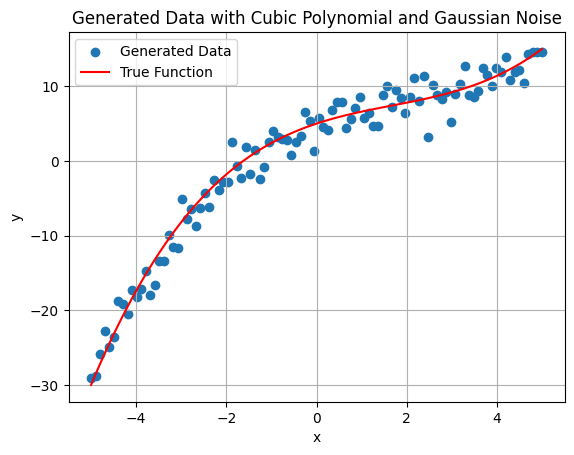

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data based on a cubic polynomial with Gaussian noise
np.random.seed(42)  # for reproducibility
n_samples = 100
x = np.linspace(-5, 5, n_samples)
# Define the true cubic polynomial function
def true_function(x):
  return 0.1 * x**3 - 0.5 * x**2 + 2 * x + 5

y_true = true_function(x)
noise = np.random.normal(0, 2, n_samples)  # Gaussian noise with mean 0 and std dev 2
y = y_true + noise

# Optional: Plot the generated data
plt.scatter(x, y, label='Generated Data')
plt.plot(x, y_true, color='red', label='True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data with Cubic Polynomial and Gaussian Noise')
plt.legend()
plt.grid(True)
plt.show()

Based on the given a dataset of input–output pairs `(x, y)` where the underlying relationship is approximately polynomial.  

a. Use a **linear model with polynomial features**: Write a function that takes an input `x` and a weight vector `w`, and return the predicted value y_hat.    
   
   - y_hat(x; w) = w0 + w1 * x + w2 * x^2 + w3 * x^3  

   where w0, w1, w2, w3 are the parameters to be learned.

b. **Loss function (Mean Squared Error)**:
   Write a function that computes the loss for one training point `(x, y)`:

     - Formula: `loss = 0.5 * (y - y_hat)**2`

c. **SGD update**:   Derive the gradient of the loss with respect to each parameter (w0, w1, w2, w3).  
   - Write a function:  

     ```python
     def sgd_update(x, y, w, alpha):
         """
         Perform one SGD update for a single training example.
         Input:
             x (float) - input value
             y (float) - true output
             w (np.array) - current weights
             alpha (float) - learning rate
         Output:
             w (np.array) - updated weights
         """
         # TODO: compute prediction, gradient, and update weights
         return w
     ```
d. **Training loop**:
   - Loop over the dataset.  
   - At each step, update the weights using `sgd_update`.  
   - Track the training loss after each iteration.  

e. **Comparison with different learning rates**  
   - Train your model using at least three different learning rates, for example:  
     - alpha = 0.001  
     - alpha = 0.01  
     - alpha = 0.1  
   - Plot training loss vs iteration for each learning rate.  
   - Plot the final fitted polynomial curves for each learning rate on the same graph with the true dataset.

---

### Deliverables
- Code for `predict`, `mse_loss`, and `sgd_update`.  
- Training loop that runs with multiple learning rates.  
- Plot of training loss vs iteration for each learning rate.  
- Plot of the fitted polynomial vs dataset for each learning rate.  
- A short discussion:
  - How does the learning rate affect convergence speed and stability?  
  - Which learning rate gives the best balance between speed and accuracy?  

Epoch    1 | MSE=19.8797 | w=[ 0.00939575  0.04677622 -0.18062541  0.20559599]
Epoch  500 | MSE=4.0250 | w=[ 4.15499379  2.33290779 -0.43870615  0.06164022]
Epoch 1000 | MSE=3.3815 | w=[ 4.61023779  2.33975649 -0.47450694  0.09054763]


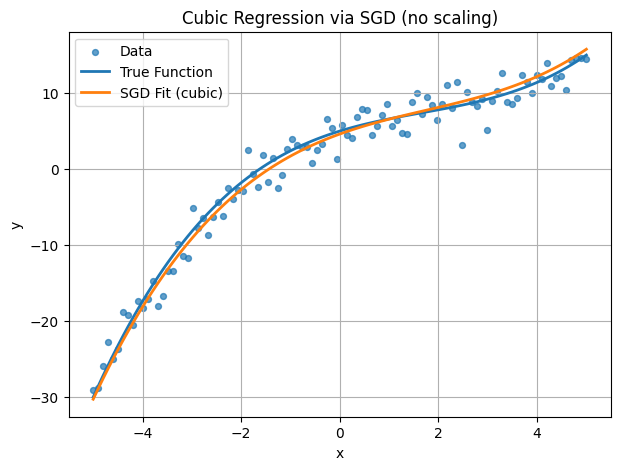

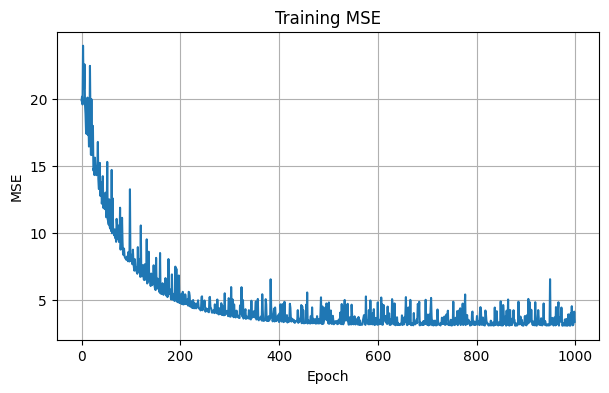

In [ ]:
## Your code here
import numpy as np
import matplotlib.pyplot as plt



def sgd_update(xi, yi, w, alpha):
    # feature vector [1, x, x^2, x^3]
    X = np.array([1.0, xi, xi**2, xi**3], dtype=float)
    y_hat = float(np.dot(w, X))
    error = y_hat - yi
    grad = error * X
    return w - alpha * grad

def predict(xs, w):
    Xmat = np.vstack([np.ones_like(xs), xs, xs**2, xs**3]).T  # (N,4)
    return Xmat @ w


w = np.zeros(4, dtype=float)   # [w0, w1, w2, w3]
epochs = 1000
alpha  = 1e-4                  # small LR since no scaling
mse_hist = []

for ep in range(1, epochs + 1):
    idx = np.random.permutation(n_samples)
    for i in idx:
        w = sgd_update(x[i], y[i], w, alpha)

    y_pred = predict(x, w)
    mse = np.mean((y_pred - y)**2)
    mse_hist.append(mse)
    if ep % 500 == 0 or ep == 1 or ep == epochs:
        print(f"Epoch {ep:4d} | MSE={mse:.4f} | w={w}")

# -----------------------------
# 4) Plots
# -----------------------------
plt.figure(figsize=(7,5))
plt.scatter(x, y, s=18, label='Data', alpha=0.7)
plt.plot(x, y_true, label='True Function', linewidth=2)
plt.plot(x, predict(x, w), label='SGD Fit (cubic)', linewidth=2)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Cubic Regression via SGD (no scaling)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.plot(mse_hist)
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training MSE')
plt.grid(True); plt.show()


## Exercise 2: 1000-State Random Walk with Semi-Gradient TD(0)

We will study the 1,000-state Random Walk a classic reinforcement learning benchmark from Sutton & Barto.  

- The environment has states numbered **1 to 1000**.  
- There are two **terminal states**:  
  - State `0` on the left (reward = 0)  
  - State `1001` on the right (reward = 1)  
- Each episode starts in the **middle** at state `500`.  
- At each step, the agent moves **left or right with equal probability (0.5 each)**.  
- The episode ends when the agent reaches either terminal.  
- Discount factor: **γ = 1.0** (episodic task).  


### Function Approximation
Instead of storing a separate value for each state, approximate the value function with a **linear function of the state index**: V_hat(s; w0, w1) = w0 + w1 * s



---

## Instructions
1. **Implement the environment**:  
   - You may **use AI tools such as ChatGPT** to generate the environment code (states, transitions, rewards).  
   - Make sure you understand how the environment works.  

2. **Implement the TD(0) update manually**:  
   - Do **not** use AI for this part.  
   - You must write the gradient update equations yourself using the formulas above.  

3. **Train your agent**:  
   - Run several episodes (e.g., 1000 episodes).  
   - Experiment with different step sizes (`alpha`).  

4. **Evaluate**:  
   - Plot the **true value function** `V*(s) = s/1001`.  
   - Plot your **learned approximation line** after training.  
   - Discuss whether the line captures the overall trend of the true values.  

---


## Guidelines on Using AI Tools
- You are encouraged to use AI tools (e.g., ChatGPT, Gemini, Copilot) to **generate helper code**, such as:  
  - Building the random walk environment (`reset`, `step`).  
  - Implementing the feature map φ(s).  
  - Plotting results.  
- However, **do not use AI tools to generate the TD(0) update equation**.  
  - Deriving and implementing the update is the key learning objective of this exercise.  
  - If we find code that uses an AI-generated update without understanding, the score will be zero.  


## Deliverables
- Python code for the environment and the TD(0) algorithm.  
- Plot the **true value function**: For state `s`, the probability of reaching the right terminal is:  
  `V*(s) = s / 1001`
- Plot comparing the true value function and the approximated line.  
- A short discussion:  
  - How does the approximation behave for small vs large states?  
  - How does the learning rate affect convergence?  

---

## Hints
- Normalize states to `[0,1]` before using them in the line approximation to avoid very large values for w1.  
- Start with small step sizes (e.g., 0.001–0.01).  
- The approximation will not be perfect (a line cannot match the true curve), but should capture the increasing trend.  


Both small and large states fit good, but the fit looks better near 0.That maybe beacause the reward 1 is come from right side，when it propagates to the left side, the error gets diluted.

If learning rate is too small the converge will very slow; in contrast, if the learning rate is too large, update will overshoot led to instability and divergence. Only in Well-scaled learning rate, we can fit very well.

<>:46: SyntaxWarning: invalid escape sequence '\h'
<>:46: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3066186683.py:46: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(states, learned_values, label="Learned $\hat V(s)$", color="red", linestyle="--")


Learned weights: 1.1529283888592648e-06 0.0010162104053584669


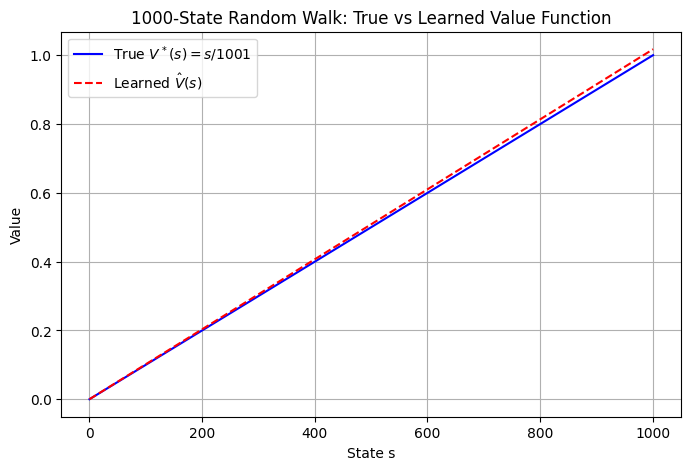

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- True Value Function ----------
def true_V(s):
    return s / 1001.0

states = np.arange(0, 1002)   # states 0..1001
true_values = true_V(states)

# ---------- TD(0) Learning ----------
LEFT, RIGHT = 0, 1001
START = 500
episodes = 1000
alpha = 1e-8

def step(s):
    if s in (LEFT, RIGHT):
        return s, 0.0, True
    s_next = s - 1 if np.random.rand() < 0.5 else s + 1
    if s_next == LEFT:   return s_next, 0.0, True
    if s_next == RIGHT:  return s_next, 1.0, True
    return s_next, 0.0, False

# weights
w0, w1 = 0.0, 0.0

for ep in range(1, episodes + 1):
    s, done = START, False
    while not done:
        s_next, r, done = step(s)
        target = r if done else w0 + w1 * s_next
        delta  = target - (w0 + w1 * s)
        w0 += alpha * delta
        w1 += alpha * delta * s
        s = s_next

print("Learned weights:", w0, w1)

# Learned approximation
learned_values = w0 + w1 * states

# ---------- Plot ----------
plt.figure(figsize=(8, 5))
plt.plot(states, true_values, label=r"True $V^*(s) = s/1001$", color="blue")
plt.plot(states, learned_values, label="Learned $\hat V(s)$", color="red", linestyle="--")
plt.xlabel("State s")
plt.ylabel("Value")
plt.title("1000-State Random Walk: True vs Learned Value Function")
plt.legend()
plt.grid(True)
plt.show()


# Exercise 3: Solving MountainCar with Tile Coding and SARSA

## Problem Description
In this exercise, you will solve the **MountainCar-v0** environment from Gym using **tile coding** for function approximation and the **SARSA algorithm** for learning.  

The **Mountain Car problem**:
- A car is stuck in a valley and is too weak to drive straight up to the goal.  
- It must build momentum by going back and forth until it can reach the goal at `position >= 0.5`.  
- **State space**: continuous (position, velocity).  
- **Actions**: {0: push left, 1: no push, 2: push right}.  
- **Reward**: -1 per step until the goal is reached.  
- **Episode ends**: when the car reaches the goal or after 200 steps.  

---

## Step 1: Environment and Random Policy (with AI help)
- Use an **AI tool (e.g., ChatGPT)** to generate starter code for:
  - Creating the Gym environment (`MountainCar-v0`).  
  - Running a **random policy** (actions chosen randomly).  
- Run this code to confirm you can interact with the environment and see episode returns.  
- This will serve as a **baseline**.  
- **Important**: Do not use AI to implement the learning algorithm.  

---

## Step 2: SARSA Algorithm with Function Approximation
Implement **SARSA (on-policy TD control)** with the following steps:

For each episode:
1. Initialize state `s`.  
2. Choose action `a` using **ε-greedy** based on Q(s,a).  
3. For each step:  
   - Take action `a`, observe `(s_next, r, done)`.  
   - Choose next action `a_next` using ε-greedy from `s_next`.  
   - Compute TD target:  
     ```
     target = r + gamma * Q(s_next, a_next)
     ```  
     (if `s_next` is terminal, then target = r).  
   - Compute TD error:  
     ```
     delta = target - Q(s,a)
     ```  
   - Update weights:  
     ```
     w <- w + alpha * delta * x(s,a)
     ```  
   - Update `s = s_next`, `a = a_next`.  
4. End episode when the goal is reached or step limit is hit.  

---

## Step 3: Experiments
- Train the agent for 500–1000 episodes.  
- Plot **episode returns (sum of rewards)** vs episodes.  
- Compare with the random policy baseline:  
  - Does SARSA learn to consistently reach the goal?  
  - How many steps does it typically take?  

---

## Deliverables
- Python code for tile coding and SARSA.  
- Plot of returns vs episodes.  
- Plot the Value function
- Short discussion (1–2 paragraphs):  
  - Effect of tile coding parameters (number of tilings, resolution).


Increasing the Number of Tilings makes the learned policy smoother and the value function more continuous, but it also requires more computational resources per iteration.
Increasing the Resolution allows each tiling to distinguish finer differences, making the policy more precise, but it also reduces the size of the region in the state–action space updated in each iteration, thus slowing down the training speed.

[Random] Episode 1/50 | Return=-200.0 | Steps=200
[Random] Episode 2/50 | Return=-200.0 | Steps=200
[Random] Episode 3/50 | Return=-200.0 | Steps=200
[Random] Episode 4/50 | Return=-200.0 | Steps=200
[Random] Episode 5/50 | Return=-200.0 | Steps=200
[Random] Episode 6/50 | Return=-200.0 | Steps=200
[Random] Episode 7/50 | Return=-200.0 | Steps=200
[Random] Episode 8/50 | Return=-200.0 | Steps=200
[Random] Episode 9/50 | Return=-200.0 | Steps=200
[Random] Episode 10/50 | Return=-200.0 | Steps=200
[Random] Episode 11/50 | Return=-200.0 | Steps=200
[Random] Episode 12/50 | Return=-200.0 | Steps=200
[Random] Episode 13/50 | Return=-200.0 | Steps=200
[Random] Episode 14/50 | Return=-200.0 | Steps=200
[Random] Episode 15/50 | Return=-200.0 | Steps=200
[Random] Episode 16/50 | Return=-200.0 | Steps=200
[Random] Episode 17/50 | Return=-200.0 | Steps=200
[Random] Episode 18/50 | Return=-200.0 | Steps=200
[Random] Episode 19/50 | Return=-200.0 | Steps=200
[Random] Episode 20/50 | Return=-200.0 |

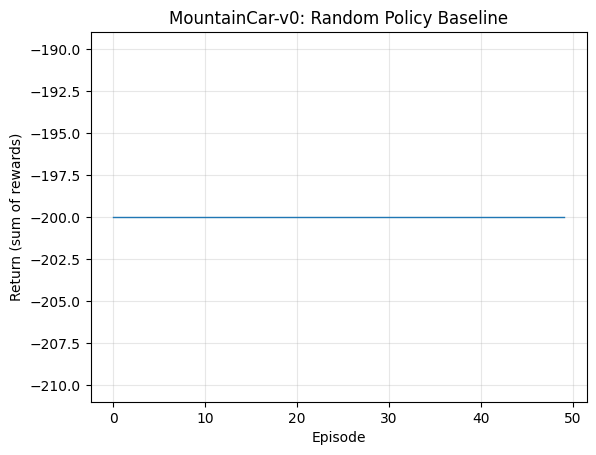

In [3]:
# random_baseline_mountaincar.py
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

def run_random_policy(env_id="MountainCar-v0", episodes=50, render=False, seed=0):
    env = gym.make(env_id)
    env.reset(seed=seed)
    rng = np.random.default_rng(seed)

    returns = []
    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        done = False
        ep_return = 0
        steps = 0
        while not done:
            if render:
                env.render()
            action = rng.integers(0, env.action_space.n)  # random action in {0,1,2}
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_return += reward
            steps += 1

        returns.append(ep_return)
        print(f"[Random] Episode {ep}/{episodes} | Return={ep_return} | Steps={steps}")

    env.close()
    return returns

if __name__ == "__main__":
    returns = run_random_policy(episodes=50, render=False)
    # Plot
    plt.figure()
    plt.plot(returns, linewidth=1)
    plt.xlabel("Episode")
    plt.ylabel("Return (sum of rewards)")
    plt.title("MountainCar-v0: Random Policy Baseline")
    plt.grid(True, alpha=0.3)
    plt.show()



=== Training SARSA + TileCoding (Direct) ===
[SARSA] Ep 100/3000 | Ret=-200.0 | MA(50)=-200.0 | Steps=200 | eps=0.272
[SARSA] Ep 200/3000 | Ret=-200.0 | MA(50)=-198.3 | Steps=200 | eps=0.246
[SARSA] Ep 300/3000 | Ret=-200.0 | MA(50)=-190.6 | Steps=200 | eps=0.222
[SARSA] Ep 400/3000 | Ret=-200.0 | MA(50)=-184.7 | Steps=200 | eps=0.201
[SARSA] Ep 500/3000 | Ret=-200.0 | MA(50)=-181.8 | Steps=200 | eps=0.182
[SARSA] Ep 600/3000 | Ret=-200.0 | MA(50)=-174.3 | Steps=200 | eps=0.165
[SARSA] Ep 700/3000 | Ret=-165.0 | MA(50)=-159.6 | Steps=165 | eps=0.149
[SARSA] Ep 800/3000 | Ret=-149.0 | MA(50)=-148.1 | Steps=149 | eps=0.135
[SARSA] Ep 900/3000 | Ret=-152.0 | MA(50)=-150.9 | Steps=152 | eps=0.122
[SARSA] Ep 1000/3000 | Ret=-114.0 | MA(50)=-141.3 | Steps=114 | eps=0.110
[SARSA] Ep 1100/3000 | Ret=-119.0 | MA(50)=-144.9 | Steps=119 | eps=0.100
[SARSA] Ep 1200/3000 | Ret=-148.0 | MA(50)=-140.4 | Steps=148 | eps=0.090
[SARSA] Ep 1300/3000 | Ret=-157.0 | MA(50)=-141.3 | Steps=157 | eps=0.082
[

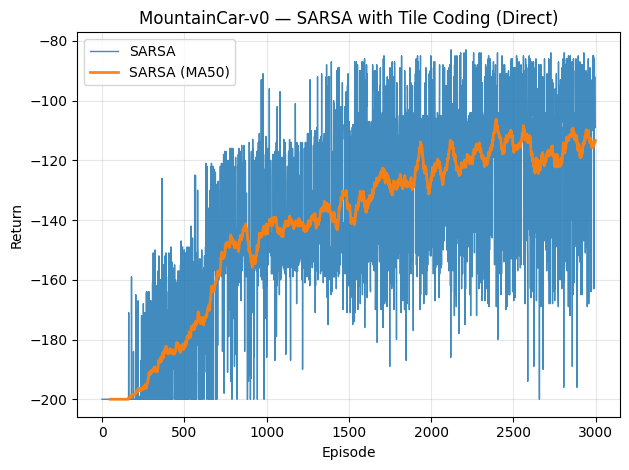

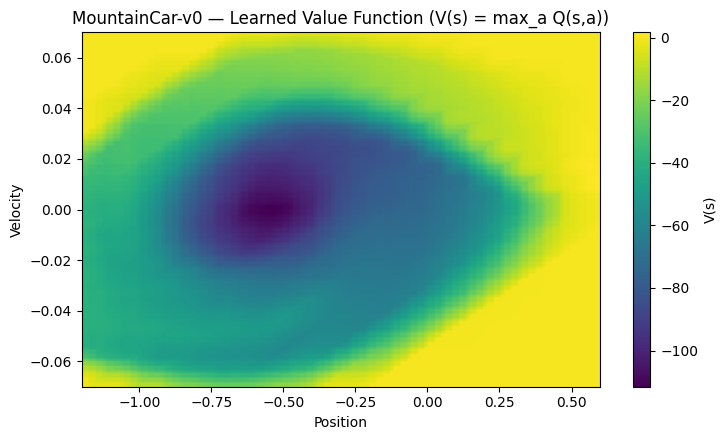


=== Evaluating Greedy Policy (ε=0) ===
[Eval] Avg steps: 103.8 | Returns: [ -85. -107.  -85. -106. -106.  -89. -106. -152. -107.  -95.]


In [4]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# =========================
# TileCoderXY
# =========================
class TileCoderXY:
    def __init__(self, num_tilings, tiles_per_dim, state_low, state_high):
        self.num_tilings = int(num_tilings)
        self.tiles_per_dim = np.array(tiles_per_dim, dtype=int)
        self.state_low  = np.array(state_low,  dtype=float)
        self.state_high = np.array(state_high, dtype=float)

        # Tile width per dimension
        self.tile_width = (self.state_high - self.state_low) / (self.tiles_per_dim - 1)

        # Staggered offsets for each tiling
        self.offsets = np.empty((self.num_tilings, 2), dtype=float)
        for i in range(self.num_tilings):
            self.offsets[i, 0] = (i / self.num_tilings) * self.tile_width[0]
            self.offsets[i, 1] = (((i + 1) % self.num_tilings) / self.num_tilings) * self.tile_width[1]

        # One weight vector per tiling (flattened 2D grid)
        num_tiles = int(self.tiles_per_dim[0] * self.tiles_per_dim[1])
        self.weights = [np.zeros(num_tiles, dtype=float) for _ in range(self.num_tilings)]

    def _active_flat_indices(self, state):
        s = np.asarray(state, dtype=float)
        shifted = (s - self.state_low) + self.offsets               # [T,2]
        coords  = (shifted / self.tile_width).astype(int)           # [T,2]
        # clamp to bounds
        coords[:, 0] = np.clip(coords[:, 0], 0, self.tiles_per_dim[0]-1)
        coords[:, 1] = np.clip(coords[:, 1], 0, self.tiles_per_dim[1]-1)
        # flatten (row-major): i * ncols + j
        flat = coords[:, 0] * self.tiles_per_dim[1] + coords[:, 1]
        return flat

    def predict(self, state):
        idxs = self._active_flat_indices(state)
        return float(sum(self.weights[t][idxs[t]] for t in range(self.num_tilings)))

    def update(self, state, target, alpha):
        pred = self.predict(state)
        err = target - pred
        step = (alpha / self.num_tilings) * err
        idxs = self._active_flat_indices(state)
        for t in range(self.num_tilings):
            self.weights[t][idxs[t]] += step


# =========================
# Utils
# =========================
def epsilon_greedy(q_vec, epsilon, rng):
    return int(rng.integers(len(q_vec))) if rng.random() < epsilon else int(np.argmax(q_vec))

def plot_returns(series_dict, ma_window=20, title="Returns over Episodes"):
    plt.figure()
    for label, arr in series_dict.items():
        arr = np.asarray(arr, float)
        plt.plot(arr, linewidth=1, alpha=0.85, label=label)
        if len(arr) >= ma_window:
            ma = np.convolve(arr, np.ones(ma_window)/ma_window, mode='valid')
            xs = np.arange(ma_window-1, ma_window-1+len(ma))
            plt.plot(xs, ma, linewidth=2, alpha=0.95, label=f"{label} (MA{ma_window})")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


# =========================
# Value function helpers
# =========================
def value_at_state(Q_tiles, s):
    """V(s) = max_a Q(s,a) using the learned tile coders."""
    return max(tc.predict(s) for tc in Q_tiles)

def compute_value_grid(Q_tiles, state_low, state_high, res=(120, 120)):
    """
    Sample V(s) on a regular grid over [state_low, state_high].
    Returns (pos, vel, V) where pos is x-axis, vel is y-axis.
    """
    pos = np.linspace(state_low[0], state_high[0], res[0])
    vel = np.linspace(state_low[1], state_high[1], res[1])
    V = np.empty((res[1], res[0]), dtype=float)  # rows=vel, cols=pos

    for j, v in enumerate(vel):
        for i, x in enumerate(pos):
            V[j, i] = value_at_state(Q_tiles, np.array([x, v], dtype=float))
    return pos, vel, V

def plot_value_function(Q_tiles, state_low, state_high, res=(150, 150),
                        title="Value Function V(s) = max_a Q(s,a)"):
    pos, vel, V = compute_value_grid(Q_tiles, state_low, state_high, res=res)
    plt.figure(figsize=(7.5, 4.5))
    plt.imshow(
        V, origin="lower", aspect="auto",
        extent=[pos[0], pos[-1], vel[0], vel[-1]]
    )
    plt.colorbar(label="V(s)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# =========================
# SARSA training
# =========================
def sarsa_train(env_id="MountainCar-v0", episodes=3000,
                gamma=1.0, alpha=0.1, epsilon=0.3,
                epsilon_decay=0.999, min_epsilon=0.01,
                num_tilings=8, tiles_per_dim=(12, 12),
                seed=0, verbose_every=100):

    env = gym.make(env_id)  # render_mode=None for training
    env.reset(seed=seed)
    rng = np.random.default_rng(seed)

    # Use first two dims: position, velocity
    state_low  = env.observation_space.low[:2]
    state_high = env.observation_space.high[:2]
    n_actions  = env.action_space.n

    # One TileCoder per action
    Q_tiles = [TileCoderXY(num_tilings, tiles_per_dim, state_low, state_high)
               for _ in range(n_actions)]

    returns, steps_list = [], []
    eps = float(epsilon)

    for ep in range(1, episodes + 1):
        s, _ = env.reset()
        s = s[:2]
        q_vec = [tc.predict(s) for tc in Q_tiles]
        a = epsilon_greedy(q_vec, eps, rng)

        done, ep_return, steps = False, 0.0, 0
        while not done:
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            s_next = s_next[:2]
            ep_return += r; steps += 1

            if not done:
                q_vec_next = [tc.predict(s_next) for tc in Q_tiles]
                a_next = epsilon_greedy(q_vec_next, eps, rng)
                target = r + gamma * Q_tiles[a_next].predict(s_next)
            else:
                target = r

            Q_tiles[a].update(s, target, alpha)

            s = s_next
            if not done:
                a = a_next

        returns.append(ep_return)
        steps_list.append(steps)

        if ep % verbose_every == 0:
            avg50 = np.mean(returns[-50:]) if len(returns) >= 50 else np.mean(returns)
            print(f"[SARSA] Ep {ep}/{episodes} | Ret={ep_return:.1f} | MA(50)={avg50:.1f} | Steps={steps} | eps={eps:.3f}")

        if epsilon_decay is not None:
            eps = max(min_epsilon, eps * epsilon_decay)

    env.close()
    return returns, steps_list, Q_tiles


# =========================
# Greedy evaluation
# =========================
def evaluate_greedy(env_id, Q_tiles, episodes=10, seed=123):
    env = gym.make(env_id)
    env.reset(seed=seed)
    steps_list, returns = [], []
    for _ in range(episodes):
        s, _ = env.reset()
        s = s[:2]
        done, ep_return, steps = False, 0.0, 0
        while not done:
            q_vec = [tc.predict(s) for tc in Q_tiles]
            a = int(np.argmax(q_vec))
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            ep_return += r; steps += 1
            s = s_next[:2]
        steps_list.append(steps)
        returns.append(ep_return)
    env.close()
    return np.array(steps_list), np.array(returns)


# =========================
# Main
# =========================
if __name__ == "__main__":
    print("\n=== Training SARSA + TileCoding (Direct) ===")
    sarsa_returns, sarsa_steps, Q_tiles = sarsa_train(
        env_id="MountainCar-v0",
        episodes=3000,
        gamma=1.0,
        alpha=0.1,
        epsilon=0.3,
        epsilon_decay=0.999,
        min_epsilon=0.02,
        num_tilings=8,
        tiles_per_dim=(12, 12),
        seed=0,
        verbose_every=100
    )

    plot_returns({"SARSA": sarsa_returns}, ma_window=50,
                 title="MountainCar-v0 — SARSA with Tile Coding (Direct)")

    # Plot value function heatmap over (position, velocity)
    tmp_env = gym.make("MountainCar-v0")
    state_low  = tmp_env.observation_space.low[:2]
    state_high = tmp_env.observation_space.high[:2]
    tmp_env.close()

    plot_value_function(
        Q_tiles, state_low, state_high,
        res=(150, 150),
        title="MountainCar-v0 — Learned Value Function (V(s) = max_a Q(s,a))"
    )

    print("\n=== Evaluating Greedy Policy (ε=0) ===")
    eval_steps, eval_returns = evaluate_greedy("MountainCar-v0", Q_tiles, episodes=10, seed=1)
    print(f"[Eval] Avg steps: {eval_steps.mean():.1f} | Returns: {eval_returns}")
